# Sentiment Analysis of Tweets Dataset using the following Machine Learning models
- Logistic Regression
- Random Forest Classifier
- Extra Trees Classifier
- Ada Boost Classifier
- Naive Bayes

In [1]:
# import required libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import string

In [2]:
# download punctuation and stopwords from nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\apfle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apfle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\apfle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\apfle\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# set up spark

# import os
# # Find the latest version of spark 3.2  from http://www.apache.org/dist/spark/ and enter as the spark version
# # For example:
# spark_version = 'spark-3.2.3'
# # spark_version = 'spark-3.<enter version>'
# os.environ['SPARK_VERSION']=spark_version

# # Install Spark and Java
# !apt-get update
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
# !tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
# !pip install -q findspark

# # Set Environment Variables
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# # Start a SparkSession
# import findspark
# findspark.init()

# Transform the data

In [4]:
# load tweets_df and view
tweets_df = pd.read_csv("Resources/Tweets.csv")


# from pyspark import SparkFiles
# url ="https://tweet-2022.s3.amazonaws.com/Tweets.csv"
# spark.sparkContext.addFile(url)
# spark_tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)
# tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)


# tweets_df = pd.read_csv("/content/Tweets.csv")
# tweets_df=spark_tweets_df.toPandas()
tweets_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [5]:
# get dataframe ready for processing

# make sure the tweets in column "text" are strings
tweets_df['text'] = tweets_df['text'].astype('str')

# delete the unneccessary columns
tweets_df = tweets_df.drop(columns=["textID", "selected_text"])

In [6]:
def process_tweets(tweet):
    # make the text all lowercase
    tweet = tweet.lower()
    
    # remove punctuation
    tweet = "".join(char for char in tweet if char not in string.punctuation)
    
    # tokenize the tweet for url clean
    tokenize_tweet_url = word_tokenize(tweet)
    
    # remove urls
    tokenize_tweet_url = " ".join([i for i in tokenize_tweet_url if 'http' not in i])
    
    # tokenize the tweet
    tokenize_tweets = word_tokenize(tokenize_tweet_url)
    
    # remove stopwords
    stopword = stopwords.words("english")
    tweet_wo_stop = [word for word in tokenize_tweets if word not in stopword]
    
    # lemmatization
    lemm = WordNetLemmatizer()
    lemmed = [lemm.lemmatize(word) for word in tweet_wo_stop]
    
    # put string together
    final_tweet = " ".join(lemmed)
    
    return final_tweet

In [7]:
# process tweets using above function
tweets_df['text'] = tweets_df['text'].apply(lambda x: process_tweets(x))
tweets_df = tweets_df.dropna()

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,neutral
1,sooo sad miss san diego,negative
2,bos bullying,negative
3,interview leave alone,negative
4,son couldnt put release already bought,negative


<AxesSubplot:ylabel='sentiment'>

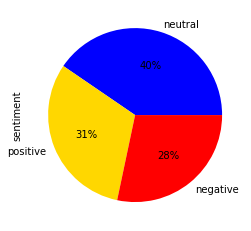

In [8]:
# visualize distribution
tweets_df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [9]:
# transform the sentiment column into numbers
dict_sentiment = {'positive': 1, 'neutral': 0, 'negative': -1}
tweets_df['sentiment'] = tweets_df['sentiment'].apply(lambda x: dict_sentiment.get(x))

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,0
1,sooo sad miss san diego,-1
2,bos bullying,-1
3,interview leave alone,-1
4,son couldnt put release already bought,-1


In [10]:
# create a separate data frame without neutral tweets
tweets_no_neut = tweets_df[tweets_df["sentiment"] != 0]

<AxesSubplot:ylabel='sentiment'>

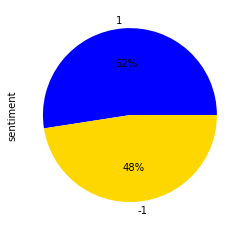

In [11]:
# visualize distribution - without neutral sentiment
tweets_no_neut.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [12]:
# Create the X and y data 
def create_train_test_data (tweets_df, train_size):
    
    # assign X and y to the input and target columns
    X = tweets_df['text']
    y = tweets_df['sentiment']

    # split the data into testing data and training data
    if train_size == 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

    # transform the data into tfidf vectors
    # fit the tfidf vectorizer on the training data to avoid bias
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test

In [13]:
# create the model
def create_model(tweets_df, attempt_num, model, train_size, notes):
    # Get the train and test data
    
    X_train_tfidf, X_test_tfidf, y_train, y_test = create_train_test_data (tweets_df, train_size)

    # create a logistic regression model and fit it to the training data
    
    model.fit(X_train_tfidf, y_train)
    training_score, testing_score, recall, precision = evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num, notes)
    
    return training_score, testing_score, recall, precision

In [14]:
# evaluate the model
def evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num, notes):
    
    training_score = model.score(X_train_tfidf, y_train)
    testing_score = model.score(X_test_tfidf, y_test)
    recall = recall_score(y_test.values, model.predict(X_test_tfidf), average='macro')
    precision = precision_score(y_test.values, model.predict(X_test_tfidf), average='macro')
    
    # look at the scores for the testing and training data
    print(f"Attempt {attempt_num}: {notes} ----------------------------------------")
    print(f"Training Data Score: {model.score(X_train_tfidf, y_train)}")
    print(f"Testing Data Score: {model.score(X_test_tfidf, y_test)} \n")

    # find metrics for testing data
    print(confusion_matrix(y_test.values, model.predict(X_test_tfidf)))
    print(classification_report(y_test.values, model.predict(X_test_tfidf)))
    
    return training_score, testing_score, recall, precision

In [15]:
# create dataframe for attempts
performance_df = pd.DataFrame(columns=["Model", "Attempt Number", "Training Score", "Testing Score", "Parameters", "Recall", "Precision", "Test_Size", "Coefficient"])
performance_df.head()

,Model,Attempt Number,Training Score,Testing Score,Parameters,Recall,Precision,Test_Size,Coefficient


## Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=100)
model2 = LogisticRegression(max_iter=300)

# models with 100 max iterations
training_score1, testing_score1, recall1, precision1 = create_model(tweets_df, 1, model, .6, "100 iterations, 60/40 split, including neutrals")
training_score2, testing_score2, recall2, precision2 = create_model(tweets_df, 2, model, .8, "100 iterations, 80/20 split, including neutrals")
training_score3, testing_score3, recall3, precision3 = create_model(tweets_no_neut, 3, model, .6, "100 iterations, 60/40 split, excluding neutrals")
training_score4, testing_score4, recall4, precision4 = create_model(tweets_no_neut, 4, model, .8, "100 iterations, 80/20 split, excluding neutrals")

performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 1, training_score1, testing_score1, 'including neutrals', recall1, precision1, .6, 100]
performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 2, training_score2, testing_score2, 'including neutrals', recall2, precision2, .8, 100]
performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 3, training_score3, testing_score3, 'excluding neutrals', recall3, precision3, .6, 100]
performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 4, training_score4, testing_score4, 'excluding neutrals', recall4, precision4, .8, 100]

# models with 300 max iterations
training_score5, testing_score5, recall5, precision5 = create_model(tweets_df, 5, model2, .6, "300 iterations, 60/40 split, including neutrals")
training_score6, testing_score6, recall6, precision6 = create_model(tweets_df, 6, model2, .8, "300 iterations, 80/20 split, including neutrals")
training_score7, testing_score7, recall7, precision7 = create_model(tweets_no_neut, 7, model2, .6, "300 iterations, 60/40 split, excluding neutrals")
training_score8, testing_score8, recall8, precision8 = create_model(tweets_no_neut, 8, model2, .8, "300 iterations, 80/20 split, excluding neutrals")

performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 5, training_score5, testing_score5, 'including neutrals', recall5, precision5, .6, 300]
performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 6, training_score6, testing_score6, 'including neutrals', recall6, precision6, .8, 300]
performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 7, training_score7, testing_score7, 'excluding neutrals', recall7, precision7, .6, 300]
performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 8, training_score8, testing_score8, 'excluding neutrals', recall8, precision8, .8, 300]

C:\Users\apfle\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Attempt 1: 100 iterations, 60/40 split, including neutrals ----------------------------------------
Training Data Score: 0.8256307617661329
Testing Data Score: 0.6824342763576822 

[[1814 1113  180]
 [ 602 3315  510]
 [ 143  943 2373]]
              precision    recall  f1-score   support

          -1       0.71      0.58      0.64      3107
           0       0.62      0.75      0.68      4427
           1       0.77      0.69      0.73      3459

    accuracy                           0.68     10993
   macro avg       0.70      0.67      0.68     10993
weighted avg       0.69      0.68      0.68     10993



C:\Users\apfle\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Attempt 2: 100 iterations, 80/20 split, including neutrals ----------------------------------------
Training Data Score: 0.8169577874818049
Testing Data Score: 0.6871020556667273 

[[ 914  563   92]
 [ 272 1639  270]
 [  69  454 1224]]
              precision    recall  f1-score   support

          -1       0.73      0.58      0.65      1569
           0       0.62      0.75      0.68      2181
           1       0.77      0.70      0.73      1747

    accuracy                           0.69      5497
   macro avg       0.71      0.68      0.69      5497
weighted avg       0.70      0.69      0.69      5497

Attempt 3: 100 iterations, 60/40 split, excluding neutrals ----------------------------------------
Training Data Score: 0.9293063053886116
Testing Data Score: 0.8632752826153376 

[[2656  392]
 [ 503 2995]]
              precision    recall  f1-score   support

          -1       0.84      0.87      0.86      3048
           1       0.88      0.86      0.87      3498

    accurac

![title](Images/LogRegImage.png)

## Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier

twitter_classi1 = RandomForestClassifier(n_estimators=100, random_state=0)
twitter_classi2 = RandomForestClassifier(n_estimators=300, random_state=0)

# models with 100 estimators
training_score1, testing_score1, recall1, precision1 = create_model(tweets_df, 1, twitter_classi1, .6, "100 estimators, 60/40 split, including neutrals")
training_score2, testing_score2, recall2, precision2 = create_model(tweets_df, 2, twitter_classi1, .8, "100 estimators, 80/20 split, including neutrals")
training_score3, testing_score3, recall3, precision3 = create_model(tweets_no_neut, 3, twitter_classi1, .6, "100 estimators, 60/40 split, excluding neutrals")
training_score4, testing_score4, recall4, precision4 = create_model(tweets_no_neut, 4, twitter_classi1, .8, "100 estimators, 80/20 split, excluding neutrals")

performance_df.loc[len(performance_df.index)] = ['Random Forest', 1, training_score1, testing_score1, 'including neutrals', recall1, precision1, .6, 100]
performance_df.loc[len(performance_df.index)] = ['Random Forest', 2, training_score2, testing_score2, 'including neutrals', recall2, precision2, .8, 100]
performance_df.loc[len(performance_df.index)] = ['Random Forest', 3, training_score3, testing_score3, 'excluding neutrals', recall3, precision3, .6, 100]
performance_df.loc[len(performance_df.index)] = ['Random Forest', 4, training_score4, testing_score4, 'excluding neutrals', recall4, precision4, .8, 100]

# models with 300 estimators
training_score5, testing_score5, recall5, precision5 = create_model(tweets_df, 5, twitter_classi2, .6, "300 estimators, 60/40 split, including neutrals")
training_score6, testing_score6, recall6, precision6 = create_model(tweets_df, 6, twitter_classi2, .8, "300 estimators, 80/20 split, including neutrals")
training_score7, testing_score7, recall7, precision7 = create_model(tweets_no_neut, 7, twitter_classi2, .6, "300 estimators, 60/40 split, excluding neutrals")
training_score8, testing_score8, recall8, precision8 = create_model(tweets_no_neut, 8, twitter_classi2, .8, "300 estimators, 80/20 split, excluding neutrals")

performance_df.loc[len(performance_df.index)] = ['Random Forest', 5, training_score5, testing_score5, 'including neutrals', recall5, precision5, .6, 300]
performance_df.loc[len(performance_df.index)] = ['Random Forest', 6, training_score6, testing_score6, 'including neutrals', recall6, precision6, .8, 300]
performance_df.loc[len(performance_df.index)] = ['Random Forest', 7, training_score7, testing_score7, 'excluding neutrals', recall7, precision7, .6, 300]
performance_df.loc[len(performance_df.index)] = ['Random Forest', 8, training_score8, testing_score8, 'excluding neutrals', recall8, precision8, .8, 300]

Attempt 1: 100 estimators, 60/40 split, including neutrals ----------------------------------------
Training Data Score: 0.997695293546822
Testing Data Score: 0.6953515873737833 

[[1824 1126  222]
 [ 495 3302  575]
 [ 122  809 2518]]
              precision    recall  f1-score   support

          -1       0.75      0.58      0.65      3172
           0       0.63      0.76      0.69      4372
           1       0.76      0.73      0.74      3449

    accuracy                           0.70     10993
   macro avg       0.71      0.69      0.69     10993
weighted avg       0.70      0.70      0.69     10993

Attempt 2: 100 estimators, 80/20 split, including neutrals ----------------------------------------
Training Data Score: 0.99745269286754
Testing Data Score: 0.6960160087320356 

[[ 913  539  119]
 [ 273 1645  306]
 [  69  365 1268]]
              precision    recall  f1-score   support

          -1       0.73      0.58      0.65      1571
           0       0.65      0.74      0.

![title](Images/RandForImage.png)

## Extra Trees Classifier

In [19]:
from sklearn.ensemble import ExtraTreesClassifier

twitter_ex1 = ExtraTreesClassifier(n_estimators=100, random_state=1)
twitter_ex2 = ExtraTreesClassifier(n_estimators=300, random_state=1)

# models with 100 estimators
training_score1, testing_score1, recall1, precision1 = create_model(tweets_df, 1, twitter_ex1, .6, "100 estimators, 60/40 split, including neutrals")
training_score2, testing_score2, recall2, precision2 = create_model(tweets_df, 2, twitter_ex1, .8, "100 estimators, 80/20 split, including neutrals")
training_score3, testing_score3, recall3, precision3 = create_model(tweets_no_neut, 3, twitter_ex1, .6, "100 estimators, 60/40 split, excluding neutrals")
training_score4, testing_score4, recall4, precision4 = create_model(tweets_no_neut, 4, twitter_ex1, .8, "100 estimators, 80/20 split, excluding neutrals")

performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 1, training_score1, testing_score1, 'including neutrals', recall1, precision1, .6, 100]
performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 2, training_score2, testing_score2, 'including neutrals', recall2, precision2, .8, 100]
performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 3, training_score3, testing_score3, 'excluding neutrals', recall3, precision3, .6, 100]
performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 4, training_score4, testing_score4, 'excluding neutrals', recall4, precision4, .8, 100]

# models with 300 estimators
training_score5, testing_score5, recall5, precision5 = create_model(tweets_df, 5, twitter_ex2, .6, "300 estimators, 60/40 split, including neutrals")
training_score6, testing_score6, recall6, precision6 = create_model(tweets_df, 6, twitter_ex2, .8, "300 estimators, 80/20 split, including neutrals")
training_score7, testing_score7, recall7, precision7 = create_model(tweets_no_neut, 7, twitter_ex2, .6, "300 estimators, 60/40 split, excluding neutrals")
training_score8, testing_score8, recall8, precision8 = create_model(tweets_no_neut, 8, twitter_ex2, .8, "300 estimators, 80/20 split, excluding neutrals")

performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 5, training_score5, testing_score5, 'including neutrals', recall5, precision5, .6, 300]
performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 6, training_score6, testing_score6, 'including neutrals', recall6, precision6, .8, 300]
performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 7, training_score7, testing_score7, 'excluding neutrals', recall7, precision7, .6, 300]
performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 8, training_score8, testing_score8, 'excluding neutrals', recall8, precision8, .8, 300]

Attempt 1: 100 estimators, 60/40 split, including neutrals ----------------------------------------
Training Data Score: 0.9979985443959243
Testing Data Score: 0.7031747475666333 

[[1987  895  235]
 [ 585 3217  657]
 [ 156  735 2526]]
              precision    recall  f1-score   support

          -1       0.73      0.64      0.68      3117
           0       0.66      0.72      0.69      4459
           1       0.74      0.74      0.74      3417

    accuracy                           0.70     10993
   macro avg       0.71      0.70      0.70     10993
weighted avg       0.71      0.70      0.70     10993

Attempt 2: 100 estimators, 80/20 split, including neutrals ----------------------------------------
Training Data Score: 0.997316229985444
Testing Data Score: 0.702746952883391 

[[ 959  486  114]
 [ 284 1592  319]
 [  75  356 1312]]
              precision    recall  f1-score   support

          -1       0.73      0.62      0.67      1559
           0       0.65      0.73      0

![title](Images/ExtTreeImage.png)

## Ada Boost Classifier

In [16]:
from sklearn.ensemble import AdaBoostClassifier

twitter_ada1 = AdaBoostClassifier(n_estimators=50, random_state=1)
twitter_ada2 = AdaBoostClassifier(n_estimators=300, random_state=1)


# models with 50 estimators
training_score1, testing_score1, recall1, precision1 = create_model(tweets_df, 1, twitter_ada1, .6, "50 estimators, 60/40 split, including neutrals")
training_score2, testing_score2, recall2, precision2 = create_model(tweets_df, 2, twitter_ada1, .8, "50 estimators, 80/20 split, including neutrals")
training_score3, testing_score3, recall3, precision3 = create_model(tweets_no_neut, 3, twitter_ada1, .6, "50 estimators, 60/40 split, excluding neutrals")
training_score4, testing_score4, recall4, precision4 = create_model(tweets_no_neut, 4, twitter_ada1, .8, "50 estimators, 80/20 split, excluding neutrals")

performance_df.loc[len(performance_df.index)] = ['Ada Boost', 1, training_score1, testing_score1, 'including neutrals', recall1, precision1, .6, 50]
performance_df.loc[len(performance_df.index)] = ['Ada Boost', 2, training_score2, testing_score2, 'including neutrals', recall2, precision2, .8, 50]
performance_df.loc[len(performance_df.index)] = ['Ada Boost', 3, training_score3, testing_score3, 'excluding neutrals', recall3, precision3, .6, 50]
performance_df.loc[len(performance_df.index)] = ['Ada Boost', 4, training_score4, testing_score4, 'excluding neutrals', recall4, precision4, .8, 50]

# models with 300 estimators
training_score5, testing_score5, recall5, precision5 = create_model(tweets_df, 5, twitter_ada2, .6, "300 estimators, 60/40 split, including neutrals")
training_score6, testing_score6, recall6, precision6 = create_model(tweets_df, 6, twitter_ada2, .8, "300 estimators, 80/20 split, including neutrals")
training_score7, testing_score7, recall7, precision7 = create_model(tweets_no_neut, 7, twitter_ada2, .6, "300 estimators, 60/40 split, excluding neutrals")
training_score8, testing_score8, recall8, precision8 = create_model(tweets_no_neut, 8, twitter_ada2, .8, "300 estimators, 80/20 split, excluding neutrals")

performance_df.loc[len(performance_df.index)] = ['Ada Boost', 5, training_score5, testing_score5, 'including neutrals', recall5, precision5, .6, 300]
performance_df.loc[len(performance_df.index)] = ['Ada Boost', 6, training_score6, testing_score6, 'including neutrals', recall6, precision6, .8, 300]
performance_df.loc[len(performance_df.index)] = ['Ada Boost', 7, training_score7, testing_score7, 'excluding neutrals', recall7, precision7, .6, 300]
performance_df.loc[len(performance_df.index)] = ['Ada Boost', 8, training_score8, testing_score8, 'excluding neutrals', recall8, precision8, .8, 300]

Attempt 1: 50 estimators, 60/40 split, including neutrals ----------------------------------------
Training Data Score: 0.6555070354196991
Testing Data Score: 0.6486855271536432 

[[1232 1668  202]
 [ 296 3633  498]
 [ 101 1097 2266]]
              precision    recall  f1-score   support

          -1       0.76      0.40      0.52      3102
           0       0.57      0.82      0.67      4427
           1       0.76      0.65      0.70      3464

    accuracy                           0.65     10993
   macro avg       0.70      0.62      0.63     10993
weighted avg       0.68      0.65      0.64     10993

Attempt 2: 50 estimators, 80/20 split, including neutrals ----------------------------------------
Training Data Score: 0.654839883551674
Testing Data Score: 0.6487174822630526 

[[ 609  907  112]
 [ 126 1803  246]
 [  43  497 1154]]
              precision    recall  f1-score   support

          -1       0.78      0.37      0.51      1628
           0       0.56      0.83      0.

![title](Images/AdaBoostImage.png)

# Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()


training_score1, testing_score1, recall1, precision1 = create_model(tweets_df, 1, mnb, .6, "60/40 split, including neutrals")
training_score2, testing_score2, recall2, precision2 = create_model(tweets_df, 2, mnb, .8, "80/20 split, including neutrals")
training_score3, testing_score3, recall3, precision3 = create_model(tweets_no_neut, 3, mnb, .6, "60/40 split, excluding neutrals")
training_score4, testing_score4, recall4, precision4 = create_model(tweets_no_neut, 4, mnb, .8, "80/20 split, excluding neutrals")

performance_df.loc[len(performance_df.index)] = ['Multinomial Naive Bayes', 1, training_score1, testing_score1, 'including neutrals', recall1, precision1, .6, 0]
performance_df.loc[len(performance_df.index)] = ['Multinomial Naive Bayes', 2, training_score2, testing_score2, 'including neutrals', recall2, precision2, .8, 0]
performance_df.loc[len(performance_df.index)] = ['Multinomial Naive Bayes', 3, training_score3, testing_score3, 'excluding neutrals', recall3, precision3, .6, 0]
performance_df.loc[len(performance_df.index)] = ['Multinomial Naive Bayes', 4, training_score4, testing_score4, 'excluding neutrals', recall4, precision4, .8, 0]

Attempt 1: 60/40 split, including neutrals ----------------------------------------
Training Data Score: 0.8054342552159146
Testing Data Score: 0.6207586646047485 

[[1226 1737  147]
 [ 309 3647  470]
 [  75 1431 1951]]
              precision    recall  f1-score   support

          -1       0.76      0.39      0.52      3110
           0       0.54      0.82      0.65      4426
           1       0.76      0.56      0.65      3457

    accuracy                           0.62     10993
   macro avg       0.69      0.59      0.61     10993
weighted avg       0.67      0.62      0.61     10993

Attempt 2: 80/20 split, including neutrals ----------------------------------------
Training Data Score: 0.7927128820960698
Testing Data Score: 0.6150627615062761 

[[ 621  910   73]
 [ 131 1799  240]
 [  33  729  961]]
              precision    recall  f1-score   support

          -1       0.79      0.39      0.52      1604
           0       0.52      0.83      0.64      2170
           1    

![title](Images/NBImage.png)

In [17]:
performance_df.to_csv("Resources/performance.csv")

![title](Images/Sentiment_Analysis_Summary.png)

### MatPlotLib

In [24]:
performance_neutral = performance_df[performance_df["Parameters"] == "including neutrals"]
performance_no_neutral = performance_df[performance_df["Parameters"] == "excluding neutrals"]

In [25]:
# with neutrals
labels = performance_neutral["Model"].tolist()
training = performance_neutral["Training Score"].tolist()
testing = performance_neutral["Testing Score"].tolist()

In [26]:
training = [round(x, 2) for x in training]
testing = [round(x, 2) for x in testing]

In [27]:
# import matplotlib.pyplot as plt
# import numpy as np
# x = np.arange(len(labels))
# width = 0.35

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, training, width, label='Training')
# rects2 = ax.bar(x + width/2, testing, width, label='Testing')

# ax.set_ylabel('Score')
# ax.set_xticks(x, labels)
# ax.xticks(rotation=45)
# ax.set_title('Scores of Models including Neutral Tweets')
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# plt.show()